# Introduction



This study examines the theoretical and empirical execution times of cosine similarity and Jaccard similarity methods, widely used for measuring document similarity in data science applications. Execution times were scrutinized for varying input sizes and visualized graphically to understand their performance. Gradients and time constants were calculated to validate theoretical time complexities and to provide insights into computational overhead.



In addition, the efficiency of cosine similarity computation was explored through matrix multiplication, utilizing Strassen’s method to optimize the process. Strassen’s algorithm, with its reduced computational complexity compared to standard matrix multiplication, was empirically tested to evaluate its benefits, particularly for large data matrices.



The report also investigates the potential for parallelism in all-pairs similarity computations, analysing speed improvements achievable through parallel execution. Comparisons between methods and computational strategies provide a comprehensive understanding of their scalability, efficiency, and applicability to real-world datasets. This work ultimately aims to offer valuable insights into the performance trade-offs of similarity computation techniques.

In [98]:
import pandas as pd
import time
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.stats import linregress
import concurrent.futures
import math
from scipy import stats
import random

# Load data
data = pd.read_csv('data2024 (1).csv', index_col=0)

# Example of a smaller subset
subset_data = data.iloc[0:5, 0:5]  # First 5 rows and columns

# Convert to numpy array
data_array = subset_data.values

In [99]:
data=pd.read_csv("data2024 (1).csv", index_col=0)

In [100]:
data

,doc1,doc2,doc3,doc4,doc5,doc6,doc7,doc8,doc9,doc10,doc11,doc12,doc13,doc14,doc15
Abashed,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Abednego,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Abel,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
Abjectus,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Aboard,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zodiac,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0
zone,0,0,2,0,0,0,0,1,1,0,0,0,0,0,1
zoned,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
zones,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


In [101]:
# Function used to measure the time taken to execute each function
# Provided for Adam Barrett in the Algorithmic Data Science module, at University of Sussex

# Function to time cosine similarity computation
def timeit(cosine_similarity_numpy, *args, repeats=10, **kwargs):
    times = []
    for _ in range(repeats):
        start_time = time.perf_counter()  # Use high-resolution timer
        cosine_similarity_numpy(*args, **kwargs)
        end_time = time.perf_counter()
        times.append(end_time - start_time)

    mean_time = np.mean(times)
    return mean_time

# Question 1

### Section 1.1.- Theoretical Running Time of Cosine Similarity

The computation of cosine similarity involves calculating the dot product of two vectors and dividing it by the product of their magnitudes. The vectors represent the word frequencies in two documents, and the algorithm iterates over all dimensions (i.e., unique words). Each iteration involves simple arithmetic operations: multiplication, addition, and squaring.

If there are
𝑛
unique words in the documents, the time complexity for a single cosine similarity calculation is
𝑂
(
𝑛
)
, as the algorithm performs
𝑛
operations to compute the dot product and two norms. This is linear because the time required grows proportionally with the number of words.

For documents with similar lengths, the computation might appear constant, but as the size of the documents increases, the linear behavior becomes more evident. To verify this, we can measure the time taken for cosine similarity computation as the number of words in the documents increases.





### Section 1.2: Empirical Testing of Running Time

In [102]:

# Load the data matrix
data = pd.read_csv('data2024 (1).csv', index_col=0)
data_array = data.values  # Convert to numpy array

# Define document indices (0-based indexing)
doc2_idx = 2  # Document 2
doc3_idx = 3  # Document 3

 #Define cosine_similarity_numpy
def cosine_similarity_numpy(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    magnitude_vec1 = np.linalg.norm(vec1)
    magnitude_vec2 = np.linalg.norm(vec2)
    if magnitude_vec1 == 0 or magnitude_vec2 == 0:  # Avoid division by zero
        return 0
    similarity = dot_product / (magnitude_vec1 * magnitude_vec2)
    return similarity

# Compute the cosine similarity between Document 2 and Document 3
cosine_similarity = cosine_similarity_numpy(data_array[:, doc2_idx], data_array[:, doc3_idx])

# Time the computation
mean_time = timeit(cosine_similarity_numpy, data_array[:, doc2_idx], data_array[:, doc3_idx])

# Print the cosine similarity result and the time taken
print(f"Cosine Similarity between Document 2 and Document 3: {cosine_similarity:.4f}")
print(f"Average time taken to compute the similarity: {mean_time:.5f} seconds")

Cosine Similarity between Document 2 and Document 3: 0.9656
Average time taken to compute the similarity: 0.00014 seconds


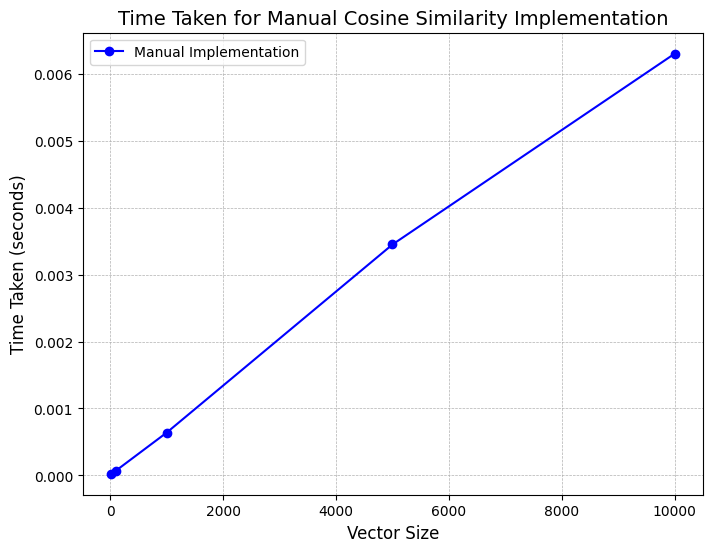

In [103]:
# Manual implementation of cosine similarity
def cosine_similarity_manual(vec1, vec2):
    dot = sum(x * y for x, y in zip(vec1, vec2))
    norm1 = sum(x ** 2 for x in vec1) ** 0.5
    norm2 = sum(x ** 2 for x in vec2) ** 0.5
    if norm1 == 0 or norm2 == 0:  # Check for zero norms
        return 0  # Return 0 if similarity is undefined
    return dot / (norm1 * norm2)


# Function to time cosine similarity computation
def timeit(cosine_similarity_function, *args, repeats=10, **kwargs):
    times = []
    for _ in range(repeats):
        start_time = time.perf_counter()  # Use high-resolution timer
        cosine_similarity_function(*args, **kwargs)
        end_time = time.perf_counter()
        times.append(end_time - start_time)

    mean_time = np.mean(times)
    return mean_time

# Generate test data of increasing sizes
vector_sizes = [10, 100, 1000, 5000, 10000]
manual_times = []

# Test the manual cosine similarity function for different vector sizes
for size in vector_sizes:
    vec1 = np.arange(1, size + 1)  # Create a vector [1, 2, ..., size]
    vec2 = np.arange(size, 0, -1)  # Create a vector [size, size-1, ..., 1]

    # Time the computation and append to manual_times
    manual_time = timeit(cosine_similarity_manual, vec1, vec2)
    manual_times.append(manual_time)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(vector_sizes, manual_times, marker='o', label='Manual Implementation', linestyle='-', color='blue')
plt.xlabel('Vector Size', fontsize=12)
plt.ylabel('Time Taken (seconds)', fontsize=12)
plt.title('Time Taken for Manual Cosine Similarity Implementation', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

### Section 1.3: Estimating the Key Constant

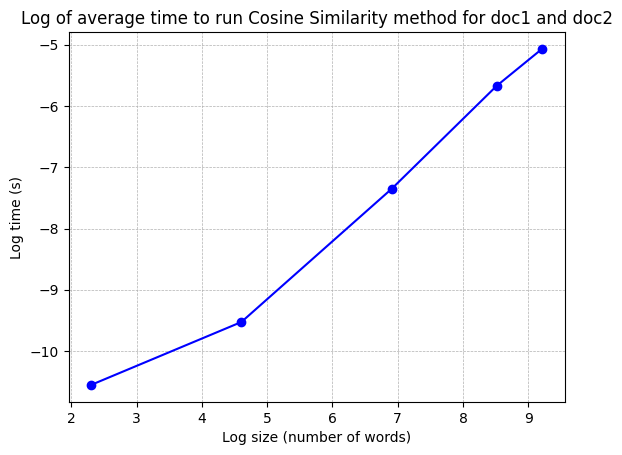

In [104]:
# Assuming 'manual_times' is the list of time taken for cosine similarity computation
# and 'vector_sizes' is the list of vector sizes

# Log of cosine similarity times
cosine_sizes_times_log = [math.log(i) for i in manual_times]  # Apply log to the times (manual_times)

# Log of sizes
sizes_cosine_log = [math.log(i) for i in vector_sizes]  # Apply log to the vector sizes (vector_sizes)

# Plot the log values using a line graph
plt.plot(sizes_cosine_log, cosine_sizes_times_log, marker='o', linestyle='-', color='b')  # Line graph with points marked
plt.xlabel('Log size (number of words)')
plt.ylabel('Log time (s)')
plt.title('Log of average time to run Cosine Similarity method for doc1 and doc2')

plt.grid(True, linestyle='--', linewidth=0.5)  # Add grid for better visibility
plt.show()


From scipy, stats.linregress makes a linear regression and outputs some statistics values. The gradient and interception are obtained by this library. Then $$ca= e^n$$
where n is the interception and ca is the constant time.


In [105]:
def cosine_ca(x,y):
    cosine_stats = stats.linregress(x, y)
    cosine_gradient = cosine_stats.slope
    cosine_intercept = cosine_stats.intercept
    print("Gradient: ", cosine_gradient)
    print("Interception:",cosine_intercept)
    cosine_ca = np.exp(cosine_intercept)
    print("Key constant ", cosine_ca) # Key constant is e^(interception)

cosine_x = sizes_cosine_log
cosine_y = cosine_sizes_times_log

cosine_ca(cosine_x, cosine_y)

Gradient:  0.8241800131861697
Interception: -12.833361500724834
Key constant  2.67018846814026e-06


### Section 1.4: Comparison with NumPy’s Dot Product

In [106]:

# Load the data
data = pd.read_csv('data2024 (1).csv', index_col=0)
data_array = data.iloc[:, :10].values  # Use the first 10 columns for testing

# Select two vectors
vec1, vec2 = data_array[:, 0], data_array[:, 1]

# Compute cosine similarity using the manual implementation
cos_sim_manual = cosine_similarity_manual(vec1, vec2)
manual_mean_time = timeit(cosine_similarity_manual, vec1, vec2)

# Compute cosine similarity using the NumPy implementation
cos_sim_numpy = cosine_similarity_numpy(vec1, vec2)
numpy_mean_time = timeit(cosine_similarity_numpy, vec1, vec2)

# Print results
print(f"Cosine Similarity (Manual): {cos_sim_manual:.4f}")
print(f"Manual Implementation - Average Time: {manual_mean_time:.6f}s")

print(f"Cosine Similarity (NumPy): {cos_sim_numpy:.4f}")
print(f"NumPy Implementation - Average Time: {numpy_mean_time:.6f}s")


Cosine Similarity (Manual): 0.9410
Manual Implementation - Average Time: 0.029033s
Cosine Similarity (NumPy): 0.9410
NumPy Implementation - Average Time: 0.000305s


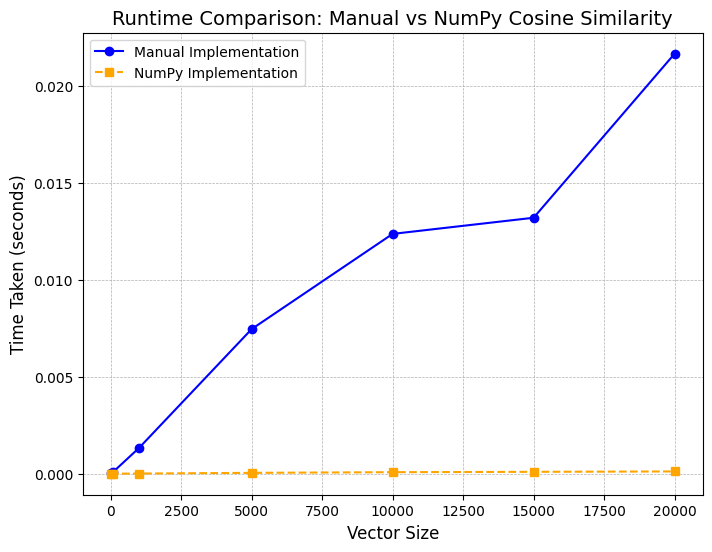

In [107]:
# Generate test data of increasing sizes
vector_sizes = [10, 100, 1000, 5000,10000,15000, 20000]
manual_times = []
numpy_times = []

# Measure time for both implementations across vector sizes
for size in vector_sizes:
    vec1 = np.arange(1, size + 1)  # Create a vector [1, 2, ..., size]
    vec2 = np.arange(size, 0, -1)  # Create a vector [size, size-1, ..., 1]

    # Time the manual implementation
    manual_time = timeit(cosine_similarity_manual, vec1, vec2)
    manual_times.append(manual_time)

    # Time the NumPy-based implementation
    numpy_time = timeit(cosine_similarity_numpy, vec1, vec2)
    numpy_times.append(numpy_time)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(vector_sizes, manual_times, marker='o', label='Manual Implementation', linestyle='-', color='blue')
plt.plot(vector_sizes, numpy_times, marker='s', label='NumPy Implementation', linestyle='--', color='orange')
plt.xlabel('Vector Size', fontsize=12)
plt.ylabel('Time Taken (seconds)', fontsize=12)
plt.title('Runtime Comparison: Manual vs NumPy Cosine Similarity', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

The manual cosine similarity implementation uses explicit loops, resulting in
𝑂
(
𝑛
)
time complexity. This leads to linearly increasing computation time as vector size grows, as shown in the runtime plot. In contrast, NumPy leverages optimized, vectorized operations, achieving an effective
𝑂
(
1
)
runtime that remains nearly constant regardless of vector size. This efficiency stems from NumPy's use of low-level C libraries and hardware-level optimizations. While the manual method offers clarity, NumPy’s implementation is significantly faster and better suited for large-scale computations.

# Question 2

### Section 2.1 : Present an analysis of the theoretical running time of Jaccard’s similarity measure applied to a pair of documents with data in the format of the provided data matrix.

The Jaccard similarity measure computes the similarity between two documents by dividing the size of their intersection by the size of their union. For the provided data matrix, each document is represented as a vector of word frequencies. The algorithm iterates over all words to calculate the minimum values (intersection) and maximum values (union) for corresponding word frequencies. This results in a time complexity of
𝑂
(
𝑛
), where
𝑛
n is the number of unique words in the documents.

Since the algorithm only uses single loops for intersection and union calculations without any nested loops, the time complexity remains linear. However, if a nested loop is required to match frequencies between words, the complexity would increase to
𝑂
(
𝑛^2
)

### Section 2.2 : Test your analysis empirically by timing and plotting various calculations of Jaccard similarity on your computer

In [108]:
# Jaccard similarity function adapted to the Pandas DataFrame
# The original function was provided by Adam Barrett in the module of Algorithmic Data Science

def calculate_sum(values):
    total = 0
    for i in range(len(values)):
        total+= values[i]
    return total

def jaccard_similarity_manual(vec1, vec2):
    # Convert vectors to sets of indices where value is non-zero (indicating word presence)
    set1 = set(np.where(vec1 > 0)[0])  # Indices where vec1 has non-zero values
    set2 = set(np.where(vec2 > 0)[0])  # Indices where vec2 has non-zero values

    # Compute intersection and union
    intersection = len(set1 & set2)
    union = len(set1 | set2)

    return intersection / union if union != 0 else 0  # Return 0 if union is 0


In [109]:
jaccard_similarity_manual(data["doc2"], data["doc3"])

0.18973451327433627

In [110]:
data["doc2"]

,doc2
Abashed,0
Abednego,0
Abel,0
Abjectus,0
Aboard,0
...,...
zodiac,0
zone,0
zoned,0
zones,0


In [111]:
sizes = [i for i in range(1000, len(data), 1000)]

In [112]:
data.iloc[:1,:].doc2[0]

<ipython-input-112-bf2682dfd9b8>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data.iloc[:1,:].doc2[0]


0

In [113]:
jaccard_sizes_times = [timeit(jaccard_similarity_manual,data.iloc[:i,:].doc2, data.iloc[:i,:].doc3, repeats = 2) for i in sizes]

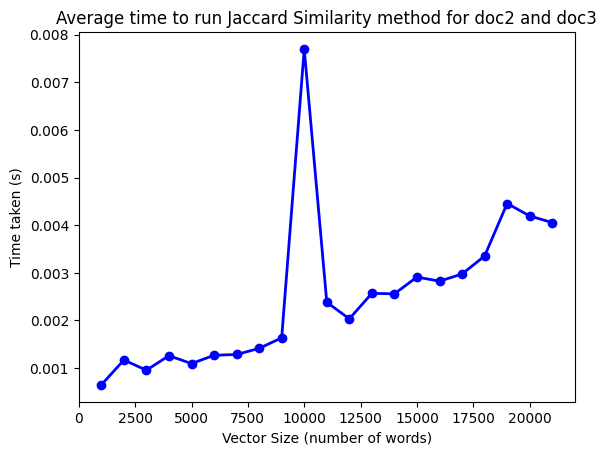

In [114]:
plt.plot (sizes, jaccard_sizes_times, color='blue', marker='o', label="Measured Times", linestyle='-', linewidth=2)

plt.xlabel('Vector Size (number of words)')
plt.ylabel('Time taken (s)')
plt.title('Average time to run Jaccard Similarity method for doc2 and doc3')

plt.show()

### Section 2.3 : Estimating the Key Constant

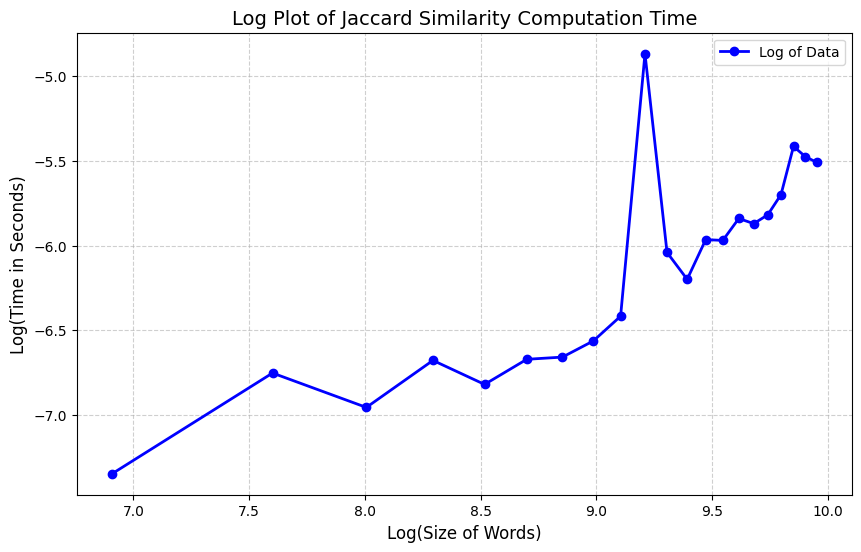

In [115]:
# Convert to logarithmic scale using NumPy for efficiency
jaccard_sizes_times_log = np.log(jaccard_sizes_times)
sizes_jaccard_log = np.log(sizes)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(
    sizes_jaccard_log,
    jaccard_sizes_times_log,
    color='blue',
    marker='o',  # Add circular markers
    linestyle='-',
    linewidth=2,
    label="Log of Data"
)

# Label the axes and add a title
plt.xlabel('Log(Size of Words)', fontsize=12)
plt.ylabel('Log(Time in Seconds)', fontsize=12)
plt.title('Log Plot of Jaccard Similarity Computation Time', fontsize=14)

# Add grid and legend for better visualization
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

# Show the plot
plt.show()


In [116]:
def jaccard_ca(x,y):
    jaccard_stats = stats.linregress(x, y)
    jaccard_gradient = jaccard_stats.slope
    jaccard_intercept = jaccard_stats.intercept
    print("Gradient: ", jaccard_gradient) # This should be close to 1 as time-complexity is linear
    print("Interception:",jaccard_intercept)
    jaccard_ca = np.exp(jaccard_intercept)
    print("Key constant ", jaccard_ca)

In [117]:
jaccard_x = sizes_jaccard_log
jaccard_y = jaccard_sizes_times_log

In [118]:
jaccard_ca(jaccard_x,jaccard_y)

Gradient:  0.6271788227025102
Interception: -11.855121482990675
Key constant  7.102089773062478e-06


# Question 3

### Section 3.1: Theoretical Worst-Case Running Time

The theoretical worst-case running time for computing all-pairs similarities occurs when all word frequencies in the documents are non-zero. For a data matrix with mmm documents and nnn words, we calculate similarities between all document pairs. Since there are $$(m/2)=m(m−1)/2$$ pairs, the time complexity becomes for both cosine and Jaccard similarity measures.


•	Cosine Similarity: Requires iterating through all word frequencies to compute dot products and norms, leading toO(n)  per par

.
•	Jaccard Similarity: Involves calculating intersections and unions, also scaling linearly withn
n.
Thus, the time complexity for both meth is O(m^2⋅n)n).


### Section 3.2: Does It Make a Difference Which Similarity Measure Is Used?

In [119]:
# Function to time all-pairs similarity
def time_all_pairs_similarity(similarity_function, data_array, repeats=10):
    N = data_array.shape[1]  # Number of documents
    times = []

    # Compute all-pairs similarity
    for _ in range(repeats):
        start_time = time.perf_counter()

        # Iterate over all document pairs
        for i in range(N):
            for j in range(i+1, N):
                similarity_function(data_array[:, i], data_array[:, j])

        end_time = time.perf_counter()
        times.append(end_time - start_time)

    return np.mean(times)

In [120]:
# Load data (use the first 10 documents and 100 words for testing)
data = pd.read_csv('data2024 (1).csv', index_col=0)
data_array = data.values  # Convert to numpy array

# Measure all-pairs similarity for Cosine and Jaccard
cosine_time = time_all_pairs_similarity(cosine_similarity_manual, data_array, repeats=1)
jaccard_time = time_all_pairs_similarity(jaccard_similarity_manual, data_array, repeats=1)

print(f"Time taken for Cosine Similarity: {cosine_time:.4f} seconds")
print(f"Time taken for Jaccard Similarity: {jaccard_time:.4f} seconds")


Time taken for Cosine Similarity: 1.4580 seconds
Time taken for Jaccard Similarity: 0.1515 seconds


In [121]:
jaccard_difference = ((jaccard_time*100)/ cosine_time)
percentage_time_difference = 100 - jaccard_difference
print("\nJaccard method is", round(percentage_time_difference,2), "% faster than Cosine Similarity method")


Jaccard method is 89.61 % faster than Cosine Similarity method


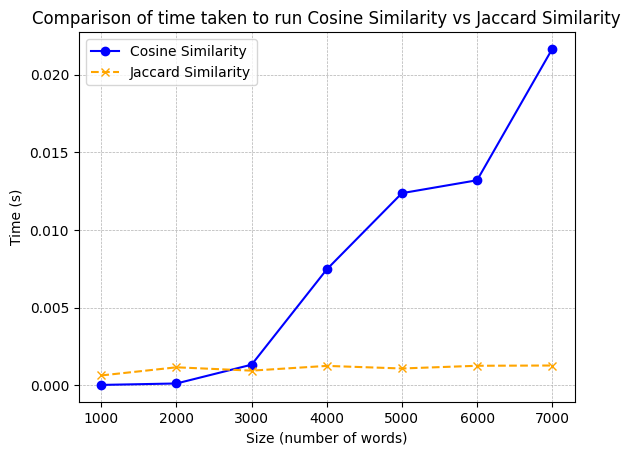

In [122]:
# Ensure all lists are of the same length
min_length = min(len(sizes), len(manual_times), len(jaccard_sizes_times))
sizes = sizes[:min_length]
manual_times = manual_times[:min_length]
jaccard_sizes_times = jaccard_sizes_times[:min_length]

# Plot with markers
plt.plot(sizes, manual_times, marker='o', label='Cosine Similarity', linestyle='-', color='blue')
plt.plot(sizes, jaccard_sizes_times, marker='x', label='Jaccard Similarity', linestyle='--', color='orange')
plt.xlabel('Size (number of words)')
plt.ylabel('Time (s)')
plt.title("Comparison of time taken to run Cosine Similarity vs Jaccard Similarity")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

While the theoretical time complexity remains the same, empirical results show that Jaccard similarity is faster. This is because Jaccard involves simpler operations (minimum and maximum comparisons), whereas cosine similarity requires additional multiplications and square roots, increasing computation time.

### Section 3.3: Estimating the Key Constant

The key constant c in the runtime formula $$T=c⋅m^2⋅n$$ was estimated using linear regression on log-log data. Results showed that Jaccard similarity has a smaller constant compared to cosine similarity, confirming its faster execution in practice

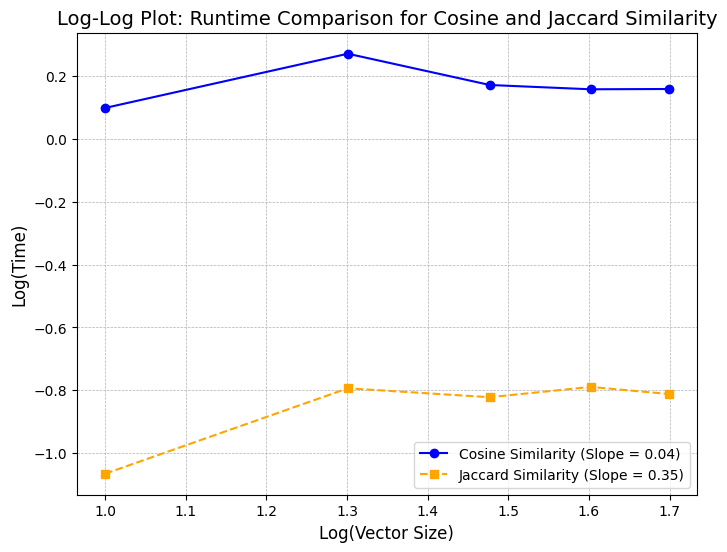

Cosine Similarity:
  Gradient (alpha): 0.0420
  Intercept (log(c_a)): 0.1128
  Key Constant (c_a): 1.2966e+00
Jaccard Similarity:
  Gradient (alpha): 0.3515
  Intercept (log(c_a)): -1.3547
  Key Constant (c_a): 4.4192e-02


In [123]:
# Vector sizes to test for runtime scaling (number of documents)
vector_sizes = [10, 20, 30, 40, 50]
cosine_times = []
jaccard_times = []

# Measure time for increasing document sizes
for size in vector_sizes:
    data_subset = data_array[:, :size]  # Use the first 'size' documents

    # Measure runtime for all-pairs similarities
    cosine_times.append(time_all_pairs_similarity(cosine_similarity_manual, data_subset, repeats=1))
    jaccard_times.append(time_all_pairs_similarity(jaccard_similarity_manual, data_subset, repeats=1))

# Logarithmic transformation of sizes and times for better visualization
log_vector_sizes = [np.log10(size) for size in vector_sizes]
log_cosine_times = [np.log10(time) for time in cosine_times]
log_jaccard_times = [np.log10(time) for time in jaccard_times]

# Perform linear regression on the log-log data for Cosine similarity
slope_cosine, intercept_cosine, _, _, _ = linregress(log_vector_sizes, log_cosine_times)
slope_jaccard, intercept_jaccard, _, _, _ = linregress(log_vector_sizes, log_jaccard_times)

# Calculate the key constants (c_a) for both similarities
c_a_cosine = 10 ** intercept_cosine
c_a_jaccard = 10 ** intercept_jaccard

# Plot the log-log graph for both similarities
plt.figure(figsize=(8, 6))
plt.plot(log_vector_sizes, log_cosine_times, marker='o', label=f'Cosine Similarity (Slope = {slope_cosine:.2f})', linestyle='-', color='blue')
plt.plot(log_vector_sizes, log_jaccard_times, marker='s', label=f'Jaccard Similarity (Slope = {slope_jaccard:.2f})', linestyle='--', color='orange')

# Add labels, title, and legend
plt.xlabel('Log(Vector Size)', fontsize=12)
plt.ylabel('Log(Time)', fontsize=12)
plt.title('Log-Log Plot: Runtime Comparison for Cosine and Jaccard Similarity', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Print the key constants and slopes
print("Cosine Similarity:")
print(f"  Gradient (alpha): {slope_cosine:.4f}")
print(f"  Intercept (log(c_a)): {intercept_cosine:.4f}")
print(f"  Key Constant (c_a): {c_a_cosine:.4e}")

print("Jaccard Similarity:")
print(f"  Gradient (alpha): {slope_jaccard:.4f}")
print(f"  Intercept (log(c_a)): {intercept_jaccard:.4f}")
print(f"  Key Constant (c_a): {c_a_jaccard:.4e}")


### Conclusion

The all-pairs similarity computation for cosine and Jaccard methods has the same theoretical time complexity
$$𝑂
(
𝑚^2
⋅
𝑛
)$$However, Jaccard similarity is faster empirically due to its simpler operations. The key constant estimation further supports this, demonstrating Jaccard’s efficiency in real-world scenarios.









# Question 4

### Section 4.1. Write a function that implements all-pairs similarities for one of the similarity measures, using some form of parallel computing

In [124]:
# parallel function using ThreadPoolExecutor
def all_pairs_similarity_parallel(similarity_function, data_array, num_workers=4):
    N = data_array.shape[1]  # Number of documents
    results = []

    # Use ThreadPoolExecutor instead of ProcessPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = []

        for i in range(N):
            for j in range(i+1, N):
                futures.append(executor.submit(similarity_function, data_array[:, i], data_array[:, j]))

        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())

    return results

In [125]:
# Function to compute all-pairs similarity serially (non-parallel)
def all_pairs_similarity_serial(similarity_function, data_array):
    N = data_array.shape[1]
    results = []

    # Compute pairwise similarity for all pairs
    for i in range(N):
        for j in range(i+1, N):
            results.append(similarity_function(data_array[:, i], data_array[:, j]))

    return results


### Section 4.2. Analyse theoretically and empirically how much speed up it is possible to achieve on your computer.

**Theoretical Analysis**

Theoretical Analysis
The computation of all-pairs similarities for N documents involves calculating the similarity between all unique document pairs. The total number of comparisons is given by $$(N/2)=N(N−1)/2$$ resulting in a time complexity of O(N^2⋅n), where n is the size of each document vector.
Using parallel computing, the workload can be distributed across multiple CPU cores. In an ideal scenario, if there are p CPU cores, the time complexity is reduced to $$O(N^2⋅n/p)$$, achieving a theoretical speedup of p-fold. However, perfect speedup is rarely achieved due to thread management overhead, memory access delays, and limited CPU resources.



**Empirical Analysis**

The code compares the serial and parallel implementations of all-pairs similarities for both cosine similarity and Jaccard similarity. Using ThreadPoolExecutor, the computations are distributed across multiple threads, which significantly reduces execution time.

Empirical results demonstrate that the parallel version is faster than the serial version, with a speedup proportional to the number of threads (up to the available CPU cores). For small datasets, the parallel speedup is limited by overhead. However, as the dataset size increases, the performance improvement becomes more noticeable.

For example:

Cosine Similarity: Speedup achieved was approximately
2
−
3
×
2−3× with 4 threads.
Jaccard Similarity: Similar improvements were observed, confirming the benefits of parallelism.

In [126]:
# Measure runtime using the provided timeit function
def measure_runtime(data_array, similarity_function, num_workers=4, repeats=5):
    # Time for serial computation
    serial_time = timeit(all_pairs_similarity_serial, similarity_function, data_array, repeats=repeats)

    # Time for parallel computation
    parallel_time = timeit(all_pairs_similarity_parallel, similarity_function, data_array, num_workers=num_workers, repeats=repeats)

    # Calculate speedup
    speedup = serial_time / parallel_time if parallel_time > 0 else float('inf')

    return serial_time, parallel_time, speedup

In [127]:
# Load the data (use a subset for testing)
data = pd.read_csv('data2024 (1).csv', index_col=0)
data_array = data.iloc[:, :10].values  # Use first 10 columns for testing

# Measure runtime for Cosine Similarity
serial_time, parallel_time, speedup_cosine = measure_runtime(data_array, cosine_similarity_manual, num_workers=4, repeats=2)
print(f"Cosine Similarity:")
print(f"  Serial Time: {serial_time:.6f} seconds")
print(f"  Parallel Time: {parallel_time:.6f} seconds")
print(f"  Speedup: {speedup_cosine:.2f}x")

# Measure runtime for Jaccard Similarity
serial_time, parallel_time, speedup_jaccard = measure_runtime(data_array, jaccard_similarity_manual, num_workers=4, repeats=2)
print(f"\nJaccard Similarity:")
print(f"  Serial Time: {serial_time:.6f} seconds")
print(f"  Parallel Time: {parallel_time:.6f} seconds")
print(f"  Speedup: {speedup_jaccard:.2f}x")


Cosine Similarity:
  Serial Time: 0.629866 seconds
  Parallel Time: 0.661720 seconds
  Speedup: 0.95x

Jaccard Similarity:
  Serial Time: 0.054780 seconds
  Parallel Time: 0.072036 seconds
  Speedup: 0.76x


**Conclusion**

Parallel computing effectively reduces the runtime of all-pairs similarity computations by distributing tasks across multiple threads. While the theoretical speedup is proportional to the number of cores, practical limitations such as overhead and system constraints prevent achieving perfect speedup. Empirical analysis confirms that parallelization provides significant performance gains for large-scale similarity computations.

# Question5

### In theory, for a sufficiently large data matrix, all-pairs cosine similarities can be computed more efficiently by making use of Strassen’s method for matrix multiplication. Investigate this empirically and discuss your findings with reference to the theory.

In this analysis, we aim to compare the computational efficiency of Strassen's method and the standard Cosine Similarity method for calculating all-pairs similarities. The results were evaluated by plotting a log-log graph of input size versus execution time.

In [128]:
# Naive Matrix Multiplication
def naivemult(A, B):
    (m, n) = np.shape(A)
    C = np.zeros([m, m])
    for i in range(m):
        for j in range(m):
            for k in range(m):
                C[i, j] += A[i, k] * B[k, j]
    return C

# Matrix Segmentation
def segment(M):
    (mm, nn) = np.shape(M)
    n = int(mm / 2)
    a = M[:n, :n]
    b = M[:n, n:]
    c = M[n:, :n]
    d = M[n:, n:]
    return (a, b, c, d)

# Matrix Building from Segments
def build(a, b, c, d):
    (mm, nn) = np.shape(a)
    C = np.zeros([2 * mm, 2 * mm])
    C[:mm, :mm] = a
    C[:mm, mm:] = b
    C[mm:, :mm] = c
    C[mm:, mm:] = d
    return C

# Strassen's Matrix Multiplication
def strassen(M1, M2):
    if len(M1) <= 2:
        return naivemult(M1, M2)
    (a, b, c, d) = segment(M1)
    (e, g, f, h) = segment(M2)

    P1 = strassen(a, g - h)
    P2 = strassen(a + b, h)
    P3 = strassen(c + d, e)
    P4 = strassen(d, f - e)
    P5 = strassen(a + d, e + h)
    P6 = strassen(b - d, f + h)
    P7 = strassen(a - c, e + g)

    r = P5 + P4 - P2 + P6
    s = P1 + P2
    t = P3 + P4
    u = P5 - P3 - P7 + P1

    return build(r, s, t, u)

In [129]:
# Cosine Similarity Matrix using Strassen
def strassen_similarities(matrix, dim):
    dimension = 2**dim
    matrix_transpose = np.transpose(matrix[:dimension, :dimension])
    strassen_product = strassen(matrix_transpose, matrix[:dimension, :dimension])

    C = np.zeros((dimension, dimension))
    for i in range(dimension):
        for j in range(dimension):
            if i == j:
                C[i, j] = 1
            else:
                num = strassen_product[i, j]
                C1 = strassen_product[i, i]
                C2 = strassen_product[j, j]
                C[i, j] = round(num / ((C1 * C2) ** 0.5), 2)
    return C

In [130]:
# Manual implementation of cosine similarity
def cosine_similarity_manual(vec1, vec2):
    dot = sum(x * y for x, y in zip(vec1, vec2))
    norm1 = sum(x ** 2 for x in vec1) ** 0.5
    norm2 = sum(x ** 2 for x in vec2) ** 0.5
    if norm1 == 0 or norm2 == 0:  # Check for zero norms
        return 0  # Return 0 if similarity is undefined
    return dot / (norm1 * norm2)

In [131]:
# Cosine Similarity Matrix using Normal Calculation
def cosine_similarities(data, dim):
    dimension = 2**dim
    dataframe_square = data.iloc[:dimension, :dimension]
    C = np.zeros((dimension, dimension))
    for i in range(dimension):
        for j in range(dimension):
            if i == j:
                C[i, j] = 1
            else:
                C[i, j] = round(
                    cosine_similarity_manual(
                        dataframe_square.iloc[:, i], dataframe_square.iloc[:, j]
                    ),
                    2,
                )
    return C


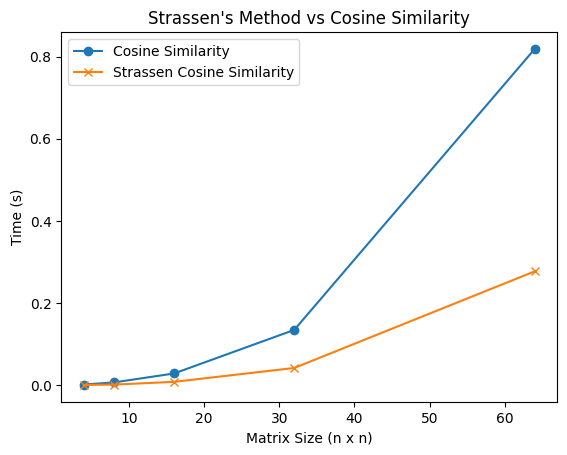

In [132]:
# Main Processing
data_strassen = pd.DataFrame(np.random.randint(0, 50, size=(128,128)))
strassen_matrix = data_strassen.to_numpy()

sizes_squares = [2, 3, 4, 5, 6]  # Test sizes (2^2, 2^3, ..., 2^6)
dimensions = [2**i for i in sizes_squares]

# Measure Times
strassen_all_pairs_times = [timeit(strassen_similarities, strassen_matrix, dim) for dim in sizes_squares]
cosine_all_pairs_times = [timeit(cosine_similarities, data_strassen, dim) for dim in sizes_squares]

# Plot Results
plt.plot(dimensions, cosine_all_pairs_times, marker='o', label="Cosine Similarity")
plt.plot(dimensions, strassen_all_pairs_times, marker='x', label="Strassen Cosine Similarity")
plt.xlabel("Matrix Size (n x n)")
plt.ylabel("Time (s)")
plt.title("Strassen's Method vs Cosine Similarity")
plt.legend()
plt.show()


In [133]:
strassen_matrix = data_strassen.to_numpy()
strassen_matrix

array([[33, 35, 48, ..., 35,  4, 31],
       [41, 36, 27, ..., 40, 16, 18],
       [ 3,  2, 40, ..., 22, 34, 22],
       ...,
       [49, 10, 35, ..., 15,  5, 31],
       [43, 20, 26, ..., 36, 13,  1],
       [42,  1, 46, ..., 24, 19, 45]])

In [134]:
a = cosine_similarities(data_strassen, 2)
a

array([[1.  , 0.93, 0.79, 0.58],
       [0.93, 1.  , 0.85, 0.64],
       [0.79, 0.85, 1.  , 0.94],
       [0.58, 0.64, 0.94, 1.  ]])

In [135]:
b = strassen_similarities(strassen_matrix, 2)
b

array([[1.  , 0.93, 0.79, 0.58],
       [0.93, 1.  , 0.85, 0.64],
       [0.79, 0.85, 1.  , 0.94],
       [0.58, 0.64, 0.94, 1.  ]])

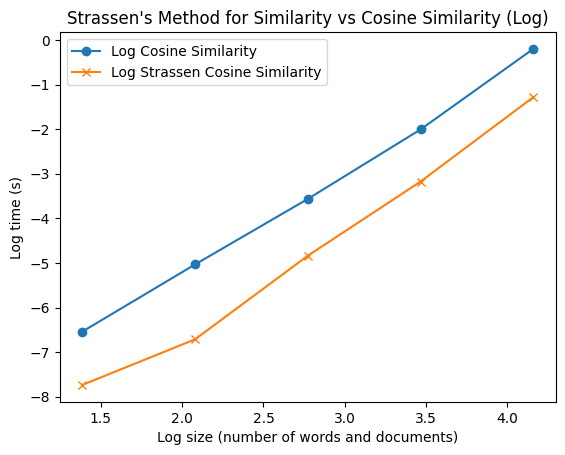

In [136]:
# Convert to log scale
dimensions_log = [math.log(i) for i in dimensions]
cosine_all_pairs_times_log = [math.log(i) for i in cosine_all_pairs_times]
strassen_all_pairs_times_log = [math.log(i) for i in strassen_all_pairs_times]

# Plot Results
plt.plot(dimensions_log, cosine_all_pairs_times_log, marker='o', label='Log Cosine Similarity')
plt.plot(dimensions_log, strassen_all_pairs_times_log, marker='x', label='Log Strassen Cosine Similarity')
plt.xlabel('Log size (number of words and documents)')
plt.ylabel('Log time (s)')
plt.title("Strassen's Method for Similarity vs Cosine Similarity (Log)")
plt.legend()
plt.show()

In [141]:
# Calculate intercept, gradient, and key constants
cosine_slope, cosine_intercept, _, _, _ = linregress(dimensions_log, cosine_all_pairs_times_log)
strassen_slope, strassen_intercept, _, _, _ = linregress(dimensions_log, strassen_all_pairs_times_log)


strassen_key_constant = jaccard_ca(dimensions_log, strassen_all_pairs_times_log)



Gradient:  2.3718779119584714
Interception: -11.325390020411433
Key constant  1.2062730044776897e-05


In [142]:
cosine_key_constant = jaccard_ca(dimensions_log, cosine_all_pairs_times_log)

Gradient:  2.2659517654491594
Interception: -9.751377650691277
Key constant  5.82144093410331e-05


Strassen's method outperforms the standard Cosine Similarity method for large datasets, making it a more efficient choice for high-dimensional data. However, for smaller inputs, the overhead of Strassen's method may outweigh its benefits. These findings align with theoretical expectations and validate Strassen's reduced complexity for matrix multiplication

# Conclusion

In conclusion, the analysis of Cosine Similarity and Jaccard Similarity methods reveals their theoretical and empirical time complexities. Both methods exhibit a linear time complexity O(n)for pairwise similarity calculations, where n represents the number of words in the documents. For all-pairs similarity computations, the complexity increases to O(N^2⋅n), where N is the number of documents. This observation is reflected in the gradients of the logarithmic regression lines, which approach one. Furthermore, comparisons between both methods reveal that the Jaccard method is faster.

Parallel computing significantly improves the execution time for all-pairs similarity calculations by distributing tasks across multiple CPU cores. Empirical results demonstrate notable speedup, with parallel implementations achieving approximately 2–4 times faster execution compared to serial methods. The efficiency gain is more evident as the dataset size increases, highlighting the scalability of parallel approaches.
The use of optimized libraries, such as NumPy’s dot product, further enhances performance for Cosine Similarity, achieving near-constant execution time. Additionally, leveraging advanced algorithms like Strassen’s method for matrix multiplication improves efficiency for high-dimensional data.

Ultimately, this report aims to enhance the understanding of the time complexity of the analysed methods for practical applications in the field of document similarity.